# 0. Imports
**Remark.** Note that some cells have "prerequisites", for instance the modules loaded below. One way to make sure you run all prerequisites is to clear the kernel and run all cells by clicking on "Runtime -> Run all" (or pressing Crtl + F9).

In [15]:
# Basics
import numpy as np
import pandas as pd
import time
import itertools as it
from itertools import combinations, permutations
import math
import bisect
import networkx as nx
import ast

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting
import seaborn as sns

# Clustering
import sklearn.cluster as skc
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Optimization
from scipy.optimize import linprog

# Technicalities
import os
import warnings
warnings.filterwarnings("ignore")

# 1. The Linear Programming Method

### 1.1. Some brief technicalities
This is needed because in practice, we have no n-ary digits for n > 10, which we use in the text. We overcome this by converting lists to strings.

In [16]:
def substrings(L):
    '''
    Converts a list L to the list of all its consecutive sublists. 
    
    IN :
    L  : List
    
    OUT:
    l  : List of consecutive sublists of L
    '''
    if len(L) < 1:
        return L
    else:
        ll = [] # Initialize the list
        for i in range(len(L) - 1): # Loop over sublist sizes
            # Start at the -ith list item; stack this for all i
            # That is: find all permutations with same order, 
            # but different starting point and stack them in a matrix
            s = np.stack([np.roll(L, -j) for j in range(i + 1)]) 
            s = np.transpose(s)[: -i] # Consider only the first n columns in the matrix
            l = [j.tolist() for j in s] # Convert from list of arrays to list of lists
            ll += l # Add all lists of size i to the list of sublists
        
        ll = [[i] for i in L] + ll + [L] # Add singular lists and L itself
    return ll

def str2list(s):
  '''
  Converts a string s of the form '<some list>' to <some list>.
  Example: str2list('[1, 2, 3]') = [1, 2, 3].
  This is required to overcome the obstacle that we don't have single digit numerals
  for any k > 9.
  '''
  t = [] # Initialization
  for i in range(len(s)):
    if s[i] == ',' or s[i] == ' ' or s[i] == '[' or s[i] == ']':
        t += [i]
  SS = sorted(list(set(range(len(s))).difference(set(t)))) # Indices of numerals in s
  
  indn = 0  # Initialization
  L    = [] # Initialization
  while len(SS) > 0:    
    indo = SS.pop(0)    # Take the first numeral index and pop it from the list of indices (INDex Old)
    k    = int(s[indo]) # Take the corresponding number in string s
    
    if len(SS) > 0:
        indn = SS[0]    # Consider the next index (INDex New)
    
    while indn == indo + 1 and len(SS) > 0: # If the indices are consecutive
        k *= 10                             # Then we have at least one more digit as number
        indn = SS.pop(0)                    # Take and remove the next index
        k += int(s[indn])                   # add it
        
        # Repeat the procedure
        indo = indn                         
        if len(SS) > 0:
            indn = SS[0]
        
    L += [k]

  return L

### 1.2. The main function
Constructs the LP-instance and solves it using the SKLearn LP solver. Note that the computation time is measured within the function, so that only the time it takes to solve the final LP is recorded (i.e. not of the construction of the graph or LP formulation). There is the freedom to choose either an interior points-method or the simplex method.

In [17]:
def mass_flow(Mass, method = 'IP', obsCons = False):
    '''
    Constructs a minimum-cost-network-flow (MCNF)-resembling graph for an instance
    of the separation problem characterised by a mass-vector M.
    
    Remark.  In comments, we will refer to vertices containing mass fractions as c(ircle) 
             vertices and decision nodes as s(quare) vertices. The set of arcs from s to c 
             is denoted by s -> c or Asc etc. etc.

    Remark.  The name of each sqaure vertex is of the form (K, L, M), a tuple 
             where K is the incident vertex of the (unique) ingoing arc and 
             L, M are the adjacent vertices, connected to the square with 
             outgoing arcs.

    Example. Round vertex [0, 1, 2] goes to two pairs of round vertices, 
             namely ([0, 1] and [2]) and ([0] and [1, 2]). Round vertex 
             [0, 1, 2] is connected to each pair through two square-vertices, 
             namely ([0, 1, 2], [0, 1], [2]) and ([0, 1, 2], [0], [1, 2]) 
             (in the same respective order as the pairs). In square vertex 
             ([0, 1, 2], [0, 1], [2]), we have K = [0, 1, 2]; L = [0, 1]; 
             M = [2]. Note that each of K, L, M are in vc.

    IN :
    M      : List of masses ("mass vector")
    method : 'IP' for Interior Points; 'Simplex' for simplex method
    obsCons: True: include "obsolete" constraints: sinks must have exactly one input stream
    
    OUT:
    opt    : The minimum (float)
    order  : The optimal order (list)
    ti     : The computation time (in seconds) of only solving the LP (float)
             (i.e. excluding the construction of the graph and LP instance)
    '''
    n = len(Mass) # number of masses
    l = list(range(n)) # List of mass indices    
    
    # Initialize vertex sets
    vc = substrings(l) # Circle vertices: all substrings of 1 : len(Mass)
    vc.sort(key = len, reverse = True)
    vs = []        # Square vertices
    
    # Initialize arc sets and arc weight sets
    acs = [] # Edges from circle to square vertices
    asc = [] # Edges from square to circle vertices
    wcs = {} # Edge weights fro cs vertices
    wsc = {} # Edge weights for sc vertices
    
    #######################################################
    ## Construct the graph: build vs, acs, asc, wcs, wsc ##
    #######################################################
    for k in vc:
        vk = [x for x in vc if len(x) < len(k)] # Look only for substrings (i.e. shorter)
        for l in vk:
            for m in vk:
                if l + m == k:
                    K = str(k)
                    L = str(l)
                    M = str(m)
                    # Add a square edge
                    vs += [(K, L, M)]
                    
                    # Add an arc (and its weight) from circle to square (cs)
                    # Arcs from circle to square are of the form
                    #    (K, (K, L, M))
                    # Where K is a round vertex and (K, L, M) is a square
                    # vertex. The notation becomes rather tedious, admittedly.
                    acs += [(K, (K, L, M))]
                    w    = 0
                    for i in k: w += Mass[i]
                    wcs[(K, (K, L, M))] = w
                    
                    # Add two arcs (weights) from square to circle (sc)
                    asc += [((K, L, M), L), ((K, L, M), M)]
                    wsc[((K, L, M), L)] = 0
                    wsc[((K, L, M), M)] = 0
                    
    vc = [str(i) for i in vc] # Vertex labels as strings
    
    #######################################################################
    ## Use the constructed graph to create a linear programming instance ##
    #######################################################################
    ## The problem instance is described as
    ##           maximize    C x
    ##           Subject to  A x = [1 0 ... 0] =: b
    ##                         x in [0, 1] for all x
    
    ## ------------------- ##
    ## ---- Finding C ---- ##
    ## ------------------- ##
    W = {**wcs, **wsc} # Merge dictionaries of sc-arc and cs-arc costs
    X = pd.DataFrame.from_dict(W, orient = 'index') # Transform the dictionary to a Pandas
                                                    # DataFrame
    C = X[:]
    C = C.T
    
    ## ------------------- ##
    ## ---- Finding A ---- ##
    ## ------------------- ##
    ## ---- Constraints on arcs of the form s -> c ---- ##
    Xsc = pd.DataFrame([[0] * (len(C.T))] * 2 * len(acs)) # We will need 2|Acs| constraints
    Xsc.columns = C.columns # We make sure that the order of the columns is the same as that of C
    Xsc.index = ['sc' + str(i) for i in Xsc.index] # Rename rows in order to join with c -> s constraints later

    # Each arc of the form s -> c is of the form ((K, L, M), L) or ((K, L, M), M). 
    # Each arc of the form c -> s is of the form (K', (K', L', M')).
    # Each square vertex has exactly one ingoing arc, hence, one parent, say K. 
    #     The constraint is: each arc (K, (K, L, M)) in c ->s should have the same 
    # value as the ingoing arc of the square vertex (K, L, M). Thus, the constraints are
    # of the form:
    #        x_((K, L, M), L) = x_(K, (K, L, M))
    #        x_((K, L, M), M) = x_(K, (K, L, M))
    # Hence,
    #        x_((K, L, M), L) - x_(K, (K, L, M)) = 0
    #        x_((K, L, M), M) - x_(K, (K, L, M)) = 0
    cc = 0
    for k in asc:
        Xsc.loc['sc' + str(cc)][k] = 1 # k = ((K, L, M), L) or k = ((K, L, M), M)
        for l in acs:
            if l[1] == k[0]: # If l = (K, (K, L, M))
                Xsc.loc['sc' + str(cc)][l] = -1 # Thus x_((K, L, M), L) - x_(K, (K, L, M)) = 0 and x_((K, L, M), M) - x_(K, (K, L, M)) = 0
        cc += 1
    
    ## ---- Constraints on arcs of the form s -> c ---- ##
    Xcs = pd.DataFrame([[0] * (len(C.T))] * len(acs)) # |Acs| is an upperbound on the number of constraints needed
    Xcs.columns = C.columns
    Xcs.index = ['cs' + str(i) for i in Xcs.index]
    
    # Arcs of the form c -> s go from a vertex of the form K to vertex of the form (K, L, M).
    # Contrary to s-vertices, c-vertices can have multiple incoming arcs and "any" number of
    # outgoing arcs. Arcs in c -> s should satisfy flow in = flow out ("flow conservation).
    # Thus:
    #        Σ_(K, L, M) x_(K, (K, L, M)) = Σ_{A, B} (x_((A, K, B), K) + x_((A, B, K), K)
    # This can be approached in a manner very similar to the constraints of the form c -> s
    
    cc  = 0
    ##########################################
    ## Experiment with obsolete constraints ##
    ##########################################
    
    if obsCons:
      vc3 = vc # In case experiment
    else:
      vc3 = [i for i in vc if len(i) > 3] # Don't consider sink-vertices (singleton lists as strings, hence, length 3)
                                        # We ignore these as they have no outgoing arcs.
    for k in vc3: # Loop through all c vertices
        for l in acs:
            if l[0] == k: # If c vertex k is the root vertex l in Acs
                Xcs.loc['cs' + str(cc)][l] = 1 
        for m in asc:
            if m[1] == k: # If k is the leaf of m in Asc
                Xcs.loc['cs' + str(cc)][m] = -1
        cc += 1
    # return Xcs
    
    # print(Xcs[Xcs.sum(axis = 1) == len(Mass) - 1])
    idx = Xcs[Xcs.sum(axis = 1) == len(Mass) - 1]
    idx = idx.index
    # Xcs = Xcs[Xcs.sum(axis = 1) != len(M) - 1] # like the sinks, we remove the source (the only vertex with n - 1 outgoing arcs)
    
    ## ---- The final equality constraint matrix A ---- ##
    A = Xcs.T.join(Xsc.T).T # Join based on columns (this is what required the indices to be distinct hence the 'cs' + str(i) mumbo jumbo)

    ## ------------------- ##
    ## ---- Finding b ---- ##
    ## ------------------- ##
    l = np.shape(A)[0]
    b = pd.DataFrame([0] * l)

    b.index = A.index
    b.loc[idx[0]]  = 1  # The total flow entering the network is equal to 1  
    
    #################################
    ## Experiment extra constraint ##
    #################################
    if obsCons:
      tnn = n * (n - 1) / 2 # Triangular number of n: This many rows for first block
      for i in range(n):
        b.iloc[int(tnn + i)] = -1 # -1 right-hand side: one inflow stream
    #################################
    ##                             ##
    ################################# 
    
    ## -------------------------------- ##
    ## ---- Lower and Upper Bounds ---- ##
    ## -------------------------------- ##
    # We have 0 <= x <= 1 for all x.
    bound = [(0, 1)] * np.shape(A)[1] # Upper and lower bounds for each variable
    
    #################################################################
    ## Solving the problem using SciPy's linear programming solver ##
    #################################################################
    c = C.values[0] # List instead of pandas DataFrame
    a = A.values
    # b is already a list!
    # bounds is also already in required shape

    if method == 'simplex': 
      t = time.clock()
      res = linprog(c, A_eq = A, b_eq = b, bounds = bound, method = 'revised simplex')
      ti  = time.clock() - t
    else:
      t = time.clock()
      res = linprog(c, A_eq = A, b_eq = b, bounds = bound) # Interior points is default
      ti  = time.clock() - t
    
    ##########################################################
    ## Translating the results back to the original problem ##
    ##########################################################
    opt = res.fun
    sol = [C.columns[i] for i in range(len(C.columns)) if res.x[i] == 1] # Basic variables
    l = [i for i in sol if type(i[0]) == str] # We only need to have the arcs of the form c -> s
                                              # These are tuples (K, (K, L, M)) with K a string.
                                              # This is opposed to arcs of the form s -> c, which
                                              # are of the form ((K, L, M), L) (or ...M), so that
                                              # the type of the 0th entry is a tuple, not a string!
    ## Computing the optimal order ##
    m = [i[1] for i in l] # Use (K, L, M) of each arc (K, (K, L, M)) in l
    order = [str2list(sd[2])[0] for sd in m]  # Separated at the first index of M (which we first convert to a list)

    return opt, order, ti, A, res.x

# 2. Dynamic programming
This is the DP-algorithm in its most primitive form.

In [18]:
def DP_sodhi(M,i,j):
    min_r  = 1000000000    
    if j - i <= 1:
        C = 0
    else:
        C      = sum(M[i:j])        
        for r in range(j - i - 1):
            k = i + r + 1
            
            cr1 = DP_sodhi(M, i, k) 
            cr2 = DP_sodhi(M, k, j)
            
            cr  = cr1 + cr2
            
            if cr < min_r:
                min_r = cr        
        C    += min_r        
    return C

# 3. Experiments

### 3.1. A quick test
Below is a test to verify that the algorithms produce the same output.

In [19]:
#Mass = [28, 21, 23, 25, 27, 32, 25, 24]
size = 10
Mass = np.random.uniform(0, 100, size)
#vmat = create_vec(len(Mass))

# Linear Programming
opt, orde, ti, A, x = mass_flow(Mass, obsCons = True)
print('Linear Programming')
print('Optimum         : ', opt)
print('Computation time: ', ti, '\n')

# Dynamic Programming
t   = time.clock()
opt = DP_sodhi(Mass, 0, len(Mass))
ti  = time.clock() - t
print('Dynamic Programming')
print('Optimum         : ', opt)
print('Computation time: ', ti, '\n')

# Vectorization
# t   = time.clock()
# opt = np.min(np.dot(np.array(vmat), Mass))
# ti  = time.clock() - t
# print('Vectorization')
# print('Optimum         : ', opt)
# print('Computation time: ', ti)

Linear Programming
Optimum         :  1147.6953848940866
Computation time:  4.983158000000003 

Dynamic Programming
Optimum         :  1147.6953832560318
Computation time:  0.32432300000004943 



**Experiment: With/without sink constraints**

Sink constraints are not strictly necessary in the LP-formulation. Here, we test whether their inclusion affects computation time.


In [ ]:
k = 0

smitt = 0
sohne = 0

while k < 50:

    size = 10
    Mass = np.random.uniform(0, 100, size)
    #vmat = create_vec(len(Mass))
    
    # Linear Programming
    opt, orde, ti, A, x = mass_flow(Mass, method = 'Simplex', obsCons = True)
    # print('With constraints')
    # print('Optimum         : ', opt)
    # print('Computation time: ', ti, '\n')
    smitt += ti

    opt, orde, ti, A, x = mass_flow(Mass, method = 'Simplex', obsCons = False)
    # print('Without constraints')
    # print('Optimum         : ', opt)
    # print('Computation time: ', ti, '\n')
    sohne += ti

    k = k + 1

In [ ]:
print('With constraints')
print('Mean computation time: ', smitt / 50, '\n')

print('Without constraints')
print('Mean computation time: ', sohne / 50, '\n')

With constraints
Mean computation time:  6.021730100000013 

Without constraints
Mean computation time:  4.675607279999995 



### 3.2. Time comparisons between the methods

Set the number of sizes. We will test randomly generated problem instances k times for each of the numbers 2 through N mass fractions

In [ ]:
N = 15

In [24]:
# Initialize vectors storing mean time complexities per problem size
MDP      = []
Msimplex = []
MIP      = []
Mip      = []
#Mvect    = []
nu       = []

for size in range(N - 1):
    size = size + 2
    
    nExp  = 10 # Number of experiments per size
    k     = 0
    
    # Initialize vectors storing time complexities
    DP      = []
    simplex = []
    IP      = []
    ip      = []
    #vect    = []
    
    #dd = d[size]
    while k < nExp:
        # Generate a random problem instance 
        M = np.random.uniform(0, 100, size)
        
        # Measure the computation time of the DP method       
        time_start = time.clock()
        DP_sodhi(M, 0, len(M))
        T_DP = time.clock() - time_start
    
        DP += [T_DP]  # store the computation time
        
        # Simlex method
        sim, x, ti, A, b = mass_flow(M, method = 'simplex')
        
        simplex += [ti]
        
        # Interior points method
        time_start = time.clock()
        sim, x, ti, A, b = mass_flow(M, method = 'IP')
        T = time.clock() - time_start
        
        IP += [T] # T: time of mass_flow(); ti: only LP solver time.
        ip += [ti]
        
        # Vectorization
        
        # time_start = time.clock()
        # np.argmin(np.dot(np.array(dd), M))
        # T = time.clock() - time_start
        
        # vect += [T]
        
        
        k += 1
    
    nu       += [size]
    MDP      += [np.mean(DP)]
    Msimplex += [np.mean(simplex)]
    MIP      += [np.mean(IP)]
    Mip      += [np.mean(ip)]
   # Mvect    += [np.mean(vect)]
    

### 3.3. Plotting the output

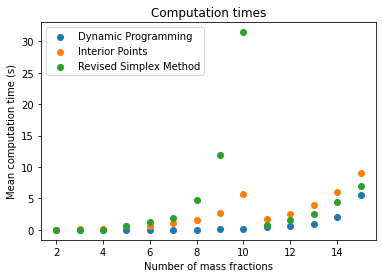

In [25]:
df = np.concatenate(([MDP], [Msimplex], [MIP]), axis = 0) 
df = pd.DataFrame(df).T
df.columns = ['DP', 'Simplex', 'Interior points']
df.index = nu

x = df.index
#plt.scatter(x, df['Vector'], label = 'Vectorization')
plt.scatter(x, df['DP'], label = 'Dynamic Programming')
plt.scatter(x, df['Interior points'], label = 'Interior Points')
plt.scatter(x, df['Simplex'], label = 'Revised Simplex Method')
plt.title('Computation times')
plt.xlabel('Number of mass fractions')
plt.ylabel('Mean computation time (s)')
plt.legend()
# plt.yscale("log")
plt.show()

# 5. Some Other Experiments


### 5.1. LP solving vs LP construction and solving
Computation time of merely solving the LP versus computation time of constructing the LP instance and solving it.

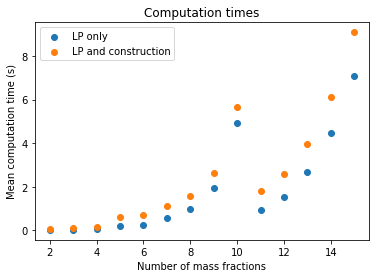

In [26]:
DF = np.concatenate(([Mip], [MIP]), axis = 0) 
DF = pd.DataFrame(DF).T
DF.columns = ['LP only', 'LP and construction']
DF.index = nu

x = DF.index
plt.scatter(x, DF['LP only'], label = 'LP only')
plt.scatter(x, DF['LP and construction'], label = 'LP and construction')

plt.title('Computation times')
plt.xlabel('Number of mass fractions')
plt.ylabel('Mean computation time (s)')
plt.legend()
# plt.yscale("log")
plt.show()

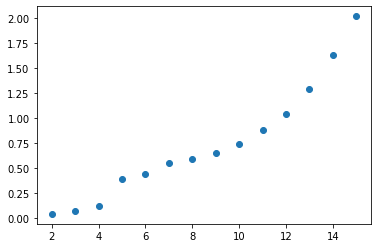

In [27]:
plt.scatter(x, DF['LP and construction'] - DF['LP only'])

### 5.2. Added value of sink constriants?
Sink constraints can be included, but are not necessary due to flow conservation.

In [29]:
k = 0

smitt = 0
sohne = 0

while k < 50:

    size = 10
    Mass = np.random.uniform(0, 100, size)
    
    # Linear Programming
    opt, orde, ti, A, x = mass_flow(Mass, method = 'Simplex', obsCons = True)
    # print('With constraints')
    # print('Optimum         : ', opt)
    # print('Computation time: ', ti, '\n')
    smitt += ti

    opt, orde, ti, A, x = mass_flow(Mass, method = 'Simplex', obsCons = False)
    # print('Without constraints')
    # print('Optimum         : ', opt)
    # print('Computation time: ', ti, '\n')
    sohne += ti

    k = k + 1

print('With constraints')
print('Mean computation time: ', smitt / 50, '\n')

print('Without constraints')
print('Mean computation time: ', sohne / 50, '\n')

With constraints
Mean computation time:  5.612170839999981 

Without constraints
Mean computation time:  4.156694159999997 



# 6. Heuristics (supplementary)

### 6.1. Center of Mass
**Algorithm ("CoM").** At each step, separate at the center of mass of the unseparated region to be divided. 

**Complexity.** $O(n)$.

**Proposition.** CoM has a worst-case-ratio of $4/3$.

**Proof sketch.** Consider mass vector

$$M = (1, \delta, \delta, 1)$$

Where $\delta = 3\epsilon/(4-6\epsilon)$ for given $\epsilon$. If $\epsilon$ is sufficiently small ($\epsilon\leq 1/3$), we now have optimal separation order $(1,3,2)$ with 

$$OPT=3+6\delta$$

whereas the CoM algorithm has cost 

$$CoM=4+4\delta$$ 

Some algebraic manipulation now shows that we can choose $\epsilon$ so that 

$$CoM/OPT = 4/3 - \epsilon$$

This type of scenario occurs whenever the mass is located aways from the center mass, thus the example with four masses .

In [30]:
def CoM(M, i, j):
    n = len(M) 
    min_r  = 1000000000
        
    if j - i == 1:
        C = 0    
    elif j - i == 2:
        C = sum(M[i:j]) # Cost of separating just two regions
    else:
        m   = np.array(M[i:j])# M restricted to [i:j]
        C   = sum(m)          # Total mass of M restricted t [i:j]
        com = C / 2             # Center of mass of M restricted to [i:j]
        
        s = np.cumsum(m)      # Array of cummulative mass
        s = np.abs(s - com)   # Subtract center of mass from cummulative masses
        k = np.argmin(s) + 1  # Index of element minimizing |cum. mass - CoM|
        # s = s - com         # Alternative way to obtain the same index
        # k = np.where(s > 0)[0][0]
        k = k + i
        
        cr1 = CoM(M, i, k) # Recursive call on subproblem 1
        cr2 = CoM(M, k, j) # Recursive call on subproblem 2
        cr  = cr1 + cr2
            
        C += cr

    return C

### 6.2. Reverse-Greedy
**Algorithm: Reverse-greedy ("RG").** Instead of considering the problem of separating masses, consider the problem of starting with only separated masses. Merge unseparated regions in every step. Choose the regions to be merged greedily, I.E. the smallest merging cost (=separation cost) at each step. Continue until only one unseparated region emerges. Now return as separation order the reverse merging order.

**Complexity.** $O(n)$.

**Proposition.** Algorithm RG is optimal if $n\leq 4$, but the worst-case ratio is unbounded if $n\geq 5$.

**Proof sketch.** We consider the case with unit cost function $f:x\mapsto x$. The resultis trivially generalized to a unit monotone increasing cost-function.

Suppose that we have an instance with $5$ masses and the RG solution (order of separation) is $(4,2,3,1)$ (that is: the optimal merging order is $(1,3,2,4)$. Becuase this order is greedy, the following inequalities must hold (referred to as Ineq. 1):

\begin{equation}
\begin{array}{lll}
m_1 + m_2 &\leq m_i + m_{i+1}  &\text{(merge $1$ first)}\\
 m_4 &\leq m_1 + m_2   &\text{(merge $3$ second)} \\
m_3  &\leq m_5 &\text{(merge $3$ second)}\\
m_1 + m_2 &\leq m_5 &\text{(merge $2$ third)}
\end{array}
\end{equation}

for $i=1,2,3,4$. The RG solution can be written in vector-multiplication format as 
$$(3,3,3,3,1)\cdot M$$

with $M$ the vector of masses. But there exists a solution with cost 
$$(3,3,2,2,2)\cdot M$$

(for example: the separation order $(3,4,2,1)$; there is an algorithm for converting vectors to separation algorithms presented in Section 7.2). We call the cost of this solution "A". Now consider

$$RG/A = ((3,3,3,3,1)\cdot M)/ ((3,3,2,2,2)\cdot M)$$

Suppose we want to maximize $OPT/RG$. Since $M$ is strictly non-negative, this is equivalent to maximizing $((3,3,3,1) - (3,3,2,2,2))\cdot M$. 

But now we can formulate the linear program

$$ Maximize z = ((3,3,3,1) - (3,3,2,2,2))\cdot M$$
$$S.t.~~ Ineq.~ 1$$

It is easily verified that this LP is unbounded. Hence, for any $x\in R$, we can find an instance $I_x$ so that

$$RG(I_x)/OPT(I_x)\geq RG(I_x)/A(I_x)\geq x$$

For $OPT(I_x)$ the theoretical optimal value of the separation problem on instance $I_x$.

In [31]:
def RG(M):
  '''
  The reverse-greedy method from the text. I will use "separation step" in comments. 
  Technically, "merging steps" is more accurate as we work in reverse.
  
  IN :
  M  : vector of masses.
  
  OUT:
  C  : Cost of separation in accordance with RG method.
  P  : Separation order in accordance with RG method.
  '''
  # Initializations #
  x = [i for i in range(len(M) - 1)] # Keeps track of separation steps not yet carried out
  P = [] 
  C = 0
  
  while len(M) > 1:
    a = [M[i] + M[i + 1] for i in range(len(M) - 1)] # Sum of masses of adjacent regions 
    am = np.argmin(a)  # Minimal index of that sum
    
    P += [x[am]] # Add the minimal argument's separation step to P
    C += a[am]   # Add the mass corresponding to the step to the cost
    
    x = x[0 : am ] + x[am + 1 :]  # Shrink x: separation step has been carried out
    
    # Replace two unseparated regions by the one obtained by merging them
    M[am + 1] = a[am]  

    M = list(M[0 : am]) + list(M[am + 1 :])
  
  P.reverse() # Reverse P as we worked in reverse
  P = [p + 1 for p in P]
  return C, P 

### 6.3. Experiments




In [32]:
me_C = []
me_r = []
ma_C = []
ma_r = []
st = []
ma = []

nu = []

mC = []
mr = []
mg = []

for size in range(N - 1):
    size = size + 2

    T_opt  = []
    T_COM  = []
    T_rg   = []
    difs_C = []
    difs_r = []
    nExp   = 100
    k      = 0
    
    while k < nExp:
        M = np.random.uniform(0, 100, size)
        
        i  = 0
        j  = len(M)
        
        #time_start = time.clock()
        OPT = DP_sodhi(M, i, j)
        #T_opt += [time.clock() - time_start]
            
        time_start = time.clock()
        COM = CoM(M, i, j)
        T_COM += [time.clock() - time_start]
                
        time_start = time.clock()
        rg, P = RG(M)
        T_rg += [time.clock() - time_start]
          
        difs_C  += [COM / OPT]
        difs_r  += [rg  / OPT]
        
        k += 1
    
    nu += [size]
    
    me_C += [np.mean(difs_C)] # Mean of differences
    #st += [np.std(difs)]  # stdev of differences
    ma_C += [max(difs_C)]     # maximum difference
    
    me_r += [np.mean(difs_r)] # Mean of differences
    #st += [np.std(difs)]  # stdev of differences
    ma_r += [max(difs_r)]     # maximum difference
    
    mC += [np.mean(T_COM)]   
    mr += [np.mean(T_rg)]
    mg += [np.mean(T_opt)]

#### Results: Deviation from optimum

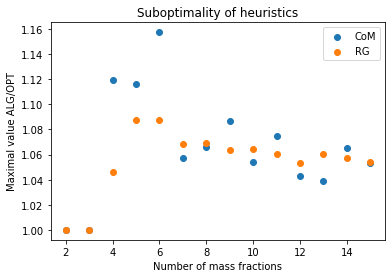

In [33]:
df = np.concatenate(([ma_C], [ma_r]), axis = 0) 
#df = np.concatenate(([me_C], [me_r]), axis = 0) 
df = pd.DataFrame(df).T
df.columns = ['CoM', 'RG']
df.index = nu
x = df.index
plt.scatter(x, df['CoM'], label = 'CoM')
plt.scatter(x, df['RG'], label = 'RG')
plt.title('Suboptimality of heuristics')
plt.xlabel('Number of mass fractions')
plt.ylabel('Maximal value ALG/OPT')
#plt.ylabel('Mean value ALG/OPT')
plt.legend()
# plt.yscale("log")
plt.show()

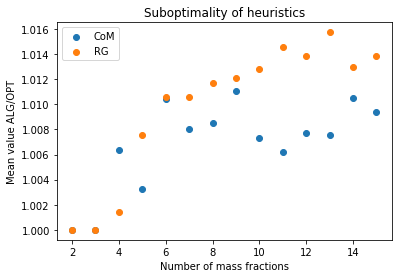

In [34]:
#df = np.concatenate(([ma_C], [ma_r]), axis = 0) 
df = np.concatenate(([me_C], [me_r]), axis = 0) 
df = pd.DataFrame(df).T
df.columns = ['CoM', 'RG']
df.index = nu

x = df.index
plt.scatter(x, df['CoM'], label = 'CoM')
plt.scatter(x, df['RG'], label = 'RG')
plt.title('Suboptimality of heuristics')
plt.xlabel('Number of mass fractions')
#plt.ylabel('Maximal value ALG/OPT')
plt.ylabel('Mean value ALG/OPT')
plt.legend()
# plt.yscale("log")
plt.show()

#### Results: computation times

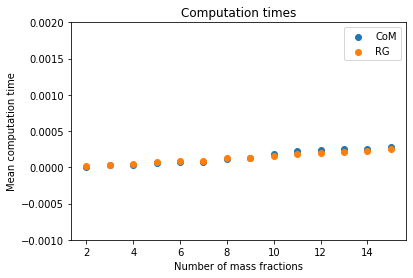

In [36]:
df = np.concatenate(([mC], [mr]), axis = 0) 
df = pd.DataFrame(df).T
df.columns = ['CoM', 'RG']
df.index = nu

x = df.index
plt.scatter(x, df['CoM'], label = 'CoM')
plt.scatter(x, df['RG'], label = 'RG')
#plt.scatter(x, df['vec'], label = 'Vectorization')
plt.title('Computation times')
plt.xlabel('Number of mass fractions')
plt.ylabel('Mean computation time')
plt.legend()
plt.axis(ymin = -0.001)
plt.axis(ymax =  0.002)
# plt.yscale("log")
plt.show()

# 7. Some Other Algorithms (supplementary)

### 7.1. Vectorization
*   Associate with each order a vector;
*   Remove symmetries;
*   Store matrix of all unique vectors (trade-off: time/memory);
*   Matrix is the same for each problem instance of size $n$; hence, matrix has to be computed/stored only once;
*   Only works for linear operation cost functions.



The following function constructs all order vectors of a given size $n$.

In [37]:
def create_vec(n):
    '''
    Creates all order vectors of size n (for n mass fractions; n-1 separation steps)
    
    IN :
    n  : number of mass fractions (int)
    
    OUT:
    N  : g(n,0) x n matrix in which each row is an order vector
    '''
    N=[]
    if n == 1:
        N = [[0]]
    elif n == 2:
        N = [[1,1]]
    else:
        m = math.ceil(n/2) # Loop through half the solutions because of symmtetry
        
        for i in range(1, m + 1):
            x = create_vec(i)     # Recursive calls for subproblems
            y = create_vec(n - i) # Recursive calls
                      
            K = []      # Some initializations
            xn = len(x) # 
            yn = len(y) # 
                      
            #  Concatenate subproblem solutions (combine each x[i] with each y[i])
            for j in range(yn):
                y[j] = [l + 1 for l in y[j]] # Add one for the current separation step
                                             # (Taken out of the nested loop to avoid repetition)
            for j in range(xn): 
                x[j] = [l + 1 for l in x[j]] # Add one for the current step
                for k in range(yn):  
                    lis = [sum([x[j],y[k]],[])]
                    K  += lis # join the x,y

            N += K # Add to the overall list
        
        # We constructed half; the other half is the mirror of this half; we add this below.
        A = np.array(N)    # Convert to np
        B = np.fliplr(A)   # flip left and right
        A = np.concatenate((A,B),axis = 0) # Add to the existing set
        A = np.unique(A, axis = 0)         # Remove duplicate rows
        N = [list(a) for a in A]           # Convert back to list
                    
    return N 

### 7.1. Conversions between vectors and permutations

More details available by request.

In [38]:
def argmax(l): return l.index(max(l)) # 'argmax'-macro
def intersection(lst1, lst2): return list(set(lst1) & set(lst2)) 

In [39]:
def vec2per(v):
    '''
    Converges an order vector v to a permutation (in list l) corresponding to it.
    '''
    l = []
    r = list(range(len(v)-1))
    w = v[:]
    
    while len(w) > 2:
        V  = max(w)
        if V == 0:
            print('Error: input is not an order vector')
            return 'No order vector'
        
        for j in range(len(r)):
            if w[j] == V and w[j+1] == V: # Group together two consecutive maxima               
                l += [r[j]]  # Add the remaining separation step between the maxima to the permutation
                w[j] -= 1    # Decrease the remaining region
                del w[j+1]   # Remove one of the regions from vector WARNING: global variable
                r.remove(r[j]) # Remove the separation step from the list of remaining steps
                break        # Terminate for and repeat
            elif w[j] == V:
                print('Error: input is not an order vector')
                return 'No order vector'
    
    l += [r[0]] # Add the remaining step
    l  = [x + 1 for x in l]
    return list(reversed(l)) # We worked backwards => reverse result

In [40]:
def per2vec(p):
    '''
    Converges separation order p to corresponding order vector v.
    '''
    
    bounds = np.array([0, len(p) + 1]) # Bounds on regions already separated
    v      = [0] * (len(p) + 1)        # The vector
    
    for i in p: # Loop through the permutation
        cut = np.where(bounds > i)
        c   = cut[len(cut) - 1][0] - 1 # Index of max_j bounds[j] < i 
        m   = bounds[c]                # max_j {bounds[j] : bounds[j] < i}
        M   = bounds[c+1]              # min_j {bounds[j] : bounds[j] > i}
        
        for j in range(m, M): # Increment the correct region of the algorithm
            v[j] += 1         # Increment the region affected by taking i as the next step
        
        b = list(bounds)
        b = b[:c+1] + [i] + b[c+1:]    # Insert i in the correct location of bounds
        bounds = np.array(b)
    return v

#### Test



In [41]:
p = [3, 4, 1, 2] # Some permutation
v = per2vec(p) # Compute the corresponding vector
print(v)
p = vec2per(v) # compute a corresponding permutation
print(p)

[2, 3, 3, 2, 2]
[3, 4, 1, 2]


Time comparison

In [42]:
N = 10 # Problem size

# A priori create matrix of all order vectors of size $N$.
d = {}
for i in range(N - 1):
  d[i + 2] = create_vec(i + 2)

In [43]:
# Initialize vectors storing mean time complexities per problem size
MDP      = []
Mvect    = []
nu       = []
N        = 10

for size in range(N - 1):
    size = size + 2
    
    nExp  = 10 # Number of experiments per size
    k     = 0
    
    # Initialize vectors storing time complexities
    DP      = []
    simplex = []
    IP      = []
    ip      = []
    vect    = []
    
    dd = d[size]
    while k < nExp:
        # Generate a random problem instance 
        M = np.random.uniform(0, 100, size)
        
        # Measure the computation time of the DP method       
        time_start = time.clock()
        DP_sodhi(M, 0, len(M))
        T_DP = time.clock() - time_start
    
        DP += [T_DP]  # store the computation time
        
        
        # Vectorization
        
        time_start = time.clock()
        np.argmin(np.dot(np.array(dd), M))
        T = time.clock() - time_start
        
        vect += [T]
        
        
        k += 1
    
    nu       += [size]
    MDP      += [np.mean(DP)]
    Mvect    += [np.mean(vect)]

In [ ]:
x = df.index
plt.scatter(x, df['Vector'], label = 'Vectorization')
plt.scatter(x, df['DP'], label = 'Dynamic Programming')
#plt.scatter(x, df['Interior points'], label = 'Linear Programming')
plt.title('Computation times')
plt.xlabel('Number of mass fractions')
plt.ylabel('Mean computation time (s)')
plt.legend()
# plt.yscale("log")
plt.show()